<a href="https://colab.research.google.com/github/trietp1253201581/KaggleCompetition/blob/main/mnist_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer

## Download and explore the data

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [2]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from zipfile import ZipFile
with ZipFile('digit-recognizer.zip') as f:
    f.extractall('digit-recognize-data')

In [4]:
import torch
import pandas as pd

In [5]:
data_dir = 'digit-recognize-data/'
raw_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')
sub_df = pd.read_csv(data_dir+'sample_submission.csv')

In [6]:
input_cols = raw_df.columns.tolist()
input_cols.remove('label')
input_cols

['pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pixel83',
 '

In [7]:
target_col = 'label'

In [8]:
for col in input_cols:
    raw_df[col] = raw_df[col]/255

In [9]:
input_tensor = torch.tensor(raw_df[input_cols].values, dtype=torch.float32)
target_tensor = torch.tensor(raw_df[target_col].values)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

In [11]:
raw_ds = TensorDataset(input_tensor, target_tensor)
raw_ds[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

tensor(9)


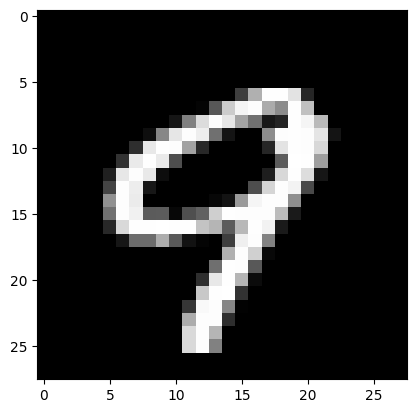

In [12]:
image_sample = raw_ds[100][0].reshape(28, 28)
import matplotlib.pyplot as plt
print(raw_ds[100][1])
plt.imshow(image_sample, cmap='gray')

In [13]:
random_seed = 42
torch.manual_seed(random_seed)

In [14]:
val_size = 8000
train_size = len(raw_ds) - val_size

In [15]:
train_ds, val_ds = torch.utils.data.random_split(raw_ds, [train_size, val_size])

In [16]:
batch_size = 128

In [17]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

## Model

In [18]:
def accurary(output, target):
    _, pred = torch.max(output, dim=1)
    return torch.tensor(torch.sum(pred==target).item()/len(target))

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        acc = accurary(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [21]:
class _2LayerNNModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32)
        self.linear2 = nn.Linear(32, 10)

    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [22]:
model = _2LayerNNModel()
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [23]:
def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [24]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [26]:
get_default_device()

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, get_default_device())
val_dl = DeviceDataLoader(val_dl, get_default_device())

In [28]:
model = to_device(_2LayerNNModel(), get_default_device())

In [29]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.3189501762390137, 'val_acc': 0.0943603515625}]

In [30]:
history += fit(5, 0.5, model, train_dl, val_dl)

Epoch [0], val_loss: 0.2709, val_acc: 0.9153
Epoch [1], val_loss: 0.2251, val_acc: 0.9324
Epoch [2], val_loss: 0.2069, val_acc: 0.9379
Epoch [3], val_loss: 0.2111, val_acc: 0.9355
Epoch [4], val_loss: 0.1599, val_acc: 0.9507


In [31]:
history += fit(5, 0.2, model, train_dl, val_dl)

Epoch [0], val_loss: 0.1399, val_acc: 0.9574
Epoch [1], val_loss: 0.1382, val_acc: 0.9590
Epoch [2], val_loss: 0.1351, val_acc: 0.9612
Epoch [3], val_loss: 0.1375, val_acc: 0.9594
Epoch [4], val_loss: 0.1341, val_acc: 0.9604


In [32]:
history += fit(5, 0.1, model, train_dl, val_dl)

Epoch [0], val_loss: 0.1298, val_acc: 0.9608
Epoch [1], val_loss: 0.1305, val_acc: 0.9602
Epoch [2], val_loss: 0.1300, val_acc: 0.9619
Epoch [3], val_loss: 0.1293, val_acc: 0.9619
Epoch [4], val_loss: 0.1298, val_acc: 0.9600


In [33]:
history += fit(5, 0.05, model, train_dl, val_dl)

Epoch [0], val_loss: 0.1282, val_acc: 0.9619
Epoch [1], val_loss: 0.1279, val_acc: 0.9618
Epoch [2], val_loss: 0.1279, val_acc: 0.9613
Epoch [3], val_loss: 0.1276, val_acc: 0.9612
Epoch [4], val_loss: 0.1280, val_acc: 0.9618


In [34]:
history += fit(5, 0.01, model, train_dl, val_dl)

Epoch [0], val_loss: 0.1277, val_acc: 0.9626
Epoch [1], val_loss: 0.1277, val_acc: 0.9626
Epoch [2], val_loss: 0.1278, val_acc: 0.9624
Epoch [3], val_loss: 0.1279, val_acc: 0.9625
Epoch [4], val_loss: 0.1277, val_acc: 0.9626


In [46]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), get_default_device())
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [38]:
test_df[input_cols] = test_df[input_cols]/255

In [47]:
test_ds = TensorDataset(torch.tensor(test_df[input_cols].values, dtype=torch.float32))

7


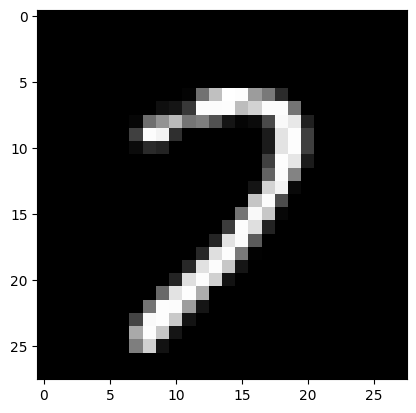

In [54]:
image_sample = test_ds[11][0].reshape(28, 28)
print(predict_image(test_ds[11][0], model))
plt.imshow(image_sample, cmap='gray')

In [52]:
for i in range(len(test_ds)):
    sub_df.loc[i, 'Label'] = predict_image(test_ds[i][0], model)

In [55]:
sub_df.to_csv('submission.csv', index=False)

In [56]:
class _3LayerNNModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [58]:
model = to_device(_3LayerNNModel(), get_default_device())

In [59]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.304136276245117, 'val_acc': 0.1109619140625}]

In [60]:
history += fit(5, 0.5, model, train_dl, val_dl)

Epoch [0], val_loss: 0.2774, val_acc: 0.9149
Epoch [1], val_loss: 0.1556, val_acc: 0.9531
Epoch [2], val_loss: 0.1236, val_acc: 0.9633
Epoch [3], val_loss: 0.1082, val_acc: 0.9667
Epoch [4], val_loss: 0.1054, val_acc: 0.9700


In [61]:
history += fit(5, 0.1, model, train_dl, val_dl)

Epoch [0], val_loss: 0.0937, val_acc: 0.9725
Epoch [1], val_loss: 0.0925, val_acc: 0.9741
Epoch [2], val_loss: 0.0938, val_acc: 0.9739
Epoch [3], val_loss: 0.0938, val_acc: 0.9735
Epoch [4], val_loss: 0.0936, val_acc: 0.9747


In [62]:
history += fit(5, 0.05, model, train_dl, val_dl)

Epoch [0], val_loss: 0.0932, val_acc: 0.9739
Epoch [1], val_loss: 0.0938, val_acc: 0.9746
Epoch [2], val_loss: 0.0931, val_acc: 0.9752
Epoch [3], val_loss: 0.0941, val_acc: 0.9744
Epoch [4], val_loss: 0.0940, val_acc: 0.9742


In [63]:
for i in range(len(test_ds)):
    sub_df.loc[i, 'Label'] = predict_image(test_ds[i][0], model)
sub_df.to_csv('submission.csv', index=False)